# Simulation Analysis
Run 1

### 1. Import Packages
Here we will be using the reading and writing tools that come with the ParFlow tools package.  

In [1]:
import xarray as xr
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd

import parflow as pf
from parflow.tools.fs import get_absolute_path
from parflow.tools.io import write_pfb, read_pfb
from parflow import Run
import parflow.tools.hydrology as hydro

#setting the directory name that we will read our outputs from
run_dir = '/glade/scratch/tijerina/CONUS2/scaling_runs/clm-update-run'
run_name = 'clm-update_CONUS2'
# run_name = 'spinup.scaling.48_36' # 'spinup.scaling.9.70_54'#
# run_dir = '/glade/scratch/tijerina/CONUS2/spinup_scaling/outputs_r1_0-25_4' #copy_spinup_scaling' #
#clm_run_dir = '/glade/scratch/tijerina/CONUS2/spinup_WY2003/run_inputs/output-clm'
print(run_dir)

/glade/scratch/tijerina/CONUS2/scaling_runs/clm-update-run


####  2. Read in the domain properties
First we will load the run from the pfidb file and get the properties using the [data_accessor](https://parflow.readthedocs.io/en/latest/tutorials/data_accessor.html?highlight=data_accessor) and by reading out the keys we need from the model object. 

In [2]:
run = Run.from_definition(f'{run_dir}/{run_name}.pfidb')
data = run.data_accessor
nt = len(data.times)
nx = data.shape[2]
ny = data.shape[1]
nz = data.shape[0]
dx = data.dx
dy = data.dy
dz = data.dz

print(nt,nx,ny,nz,dx,dy,dz)

porosity = data.computed_porosity 
specific_storage = data.specific_storage 
#mannings = pf.read_pfb(f'{run_dir}/spinup.scaling.48_36.out.n.pfb') #run.Mannings.Geom.domain.Value
mannings = data.mannings

## remove input filenames for TopoSlopes to force the data accessor to read the output slopes
## this fixes a windows issue
run.TopoSlopesX.FileName = None
run.TopoSlopesY.FileName = None

slopex = data.slope_x 
slopey = data.slope_y 
mask = data.mask

# formatting the mask so that values outside the domain are NA and inside the domain are 1
# check with mask that has 0 and 1
nanmask=mask.copy()
#nanmask[nanmask == 0] = 'NaN'
nanmask[nanmask > 0] = 1

Solver: Field BinaryOutDir is not part of the expected schema <class 'parflow.tools.database.generated.Solver'>
Solver.OverlandKinematic: Field SeepageOne is not part of the expected schema <class 'parflow.tools.database.generated.OverlandKinematic'>
Solver.OverlandKinematic: Field SeepageTwo is not part of the expected schema <class 'parflow.tools.database.generated.OverlandKinematic'>
  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
97 4442 3256 10 1000.0 1000.0 [2.0e+02 1.0e+02 5.0e+01 2.5e+01 1.0e+01 5.0e+00 1.0e+00 6.0e-01 3.0e-01
 1.0e-01]


In [8]:
nt

97

In [4]:
nanmask[9,2000:2005,2000:2005]

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [5]:
print(mannings.shape)

(1, 3256, 4442)


#### 4. Read the simulation output files

In [6]:
#list all pressure files from outputs
lw_press_files = glob(f'{run_dir}/{run_name}.out.press*.pfb')
#print(lw_press_files)
#read in all pressure files into a 3D NParray
pressure_arrays = pf.read_pfb_sequence(lw_press_files) * nanmask

#list all saturation files from outputs
lw_satur_files = glob(f'{run_dir}/{run_name}.out.satur*.pfb')
#read in all pressure files into a 3D NParray
saturation_arrays = pf.read_pfb_sequence(lw_satur_files) * nanmask

In [9]:
nt = 25

#### 5. Calculate water balance
We will be using the hydrology tools to calculate the water balance. You can find more information on the tools [here](https://parflow.readthedocs.io/en/latest/tutorials/hydrology.html).

In [10]:
subsurface_storage = np.zeros(nt)
surface_storage = np.zeros(nt)
wtd = np.zeros((nt, ny, nx))
et = np.zeros(nt)
overland_flow = np.zeros((nt, ny, nx))
data.time = 0

for i, (pressure, saturation) in enumerate(zip(pressure_arrays, saturation_arrays)):
    subsurface_storage[i, ...] = np.sum(hydro.calculate_subsurface_storage(porosity, pressure, saturation, specific_storage, dx, dy, dz, mask = nanmask),axis=(0, 1, 2))
    # total surface storage for this time step is the summation of substorage surface across all x/y slices
    surface_storage[i, ...] = np.sum( hydro.calculate_surface_storage(pressure, dx, dy, mask = nanmask),axis=(0, 1))
    wtd[i, ...] = hydro.calculate_water_table_depth(pressure, saturation, dz)
    
    data.time = i
    if i != 0:
        if data.et is not None:
            # total ET for this time step is the summation of ET values across all x/y/z slices
            et[i, ...] = np.sum(hydro.calculate_evapotranspiration(data.et, dx, dy, dz, mask = nanmask),axis=(0, 1, 2))

 
    overland_flow[i, ...] = hydro.calculate_overland_flow_grid(pressure, slopex, slopey, mannings, dx, dy, mask = nanmask)

In [7]:
print(pressure_arrays.shape)
print(saturation_arrays.shape)

(25, 10, 3256, 4442)
(25, 10, 3256, 4442)


#### Look at some variable arrays

In [11]:
print(f'Overland Flow Shape: {overland_flow.shape}')
print(f'Max Overland Flow: {overland_flow.max()}')
print(f'Min Overland Flow: {overland_flow.min()}')
print(f'WTD Shape: {wtd.shape}')
print(f'Max WTD: {wtd.max()}')
print(f'Min WTD: {wtd.min()}')
print(f'Overland Flow at River: {overland_flow[24,4280:4285,2771:2776]}')
print(f'WTD somewhere: {wtd[5,2000:2005,2000:2005]}')
print(f'Surf Storage Shape: {surface_storage.shape}')
print(f'ET Shape: {et.shape}')

Overland Flow Shape: (25, 3256, 4442)
Max Overland Flow: 4774586827.056005
Min Overland Flow: 0.0
WTD Shape: (25, 3256, 4442)
Max WTD: 296.9175407994233
Min WTD: 0.0
Overland Flow at River: []
WTD somewhere: [[ 0.04973598  2.30068013  7.01026564  0.04963241  5.83035748]
 [ 5.33807491  6.08580938  7.42565634  0.04979845  9.39279174]
 [ 2.28496138  9.49597752  6.7998627   1.37927503  7.20354399]
 [ 7.03311986 16.57708551  8.171154    7.06899189 13.32270286]
 [31.1238349  21.78819507  6.64585275  6.66863278 12.51305061]]
Surf Storage Shape: (25,)
ET Shape: (25,)


In [12]:
data.et.shape

(3256, 4442)

In [13]:
print(et)
print(subsurface_storage)
print(surface_storage)

[0.00000000e+00 4.04417410e+10 2.88353153e+10 2.45298517e+10
 2.09183079e+10 1.85715052e+10 1.71978733e+10 1.59296551e+10
 1.40908069e+10 1.29383281e+10 1.19803308e+10 1.16584010e+10
 1.18705488e+10 1.53405948e+10 3.41278326e+10 6.05648833e+10
 9.38369126e+10 1.22817024e+11 1.44932776e+11 1.55650890e+11
 1.50752258e+11 1.36754332e+11 1.13586648e+11 7.98274410e+10
 4.67460252e+10]
[1.02219774e+15 1.02219792e+15 1.02219807e+15 1.02219824e+15
 1.02219836e+15 1.02219844e+15 1.02219853e+15 1.02219862e+15
 1.02219866e+15 1.02219867e+15 1.02219869e+15 1.02219870e+15
 1.02219871e+15 1.02219871e+15 1.02219867e+15 1.02219851e+15
 1.02219817e+15 1.02219761e+15 1.02219685e+15 1.02219598e+15
 1.02219511e+15 1.02219430e+15 1.02219364e+15 1.02219318e+15
 1.02219295e+15]
[6.16737549e+10 6.57166100e+10 6.97982425e+10 7.39389517e+10
 7.80203545e+10 8.20772209e+10 8.61506991e+10 9.02793564e+10
 9.44743656e+10 9.88119096e+10 1.03336524e+11 1.08091408e+11
 1.13107863e+11 1.18407084e+11 1.23949021e+11 1.297

#### Plot Static maps of the simulation outputs

(25, 3256, 4442)
(25, 10, 3256, 4442)


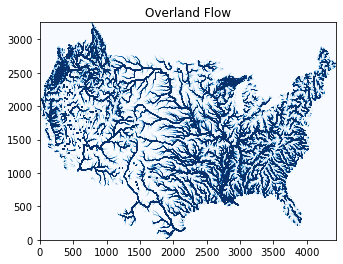

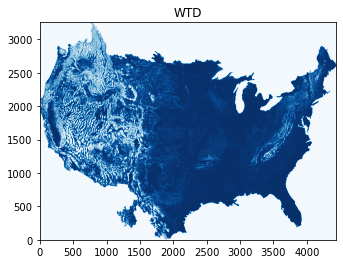

('eflx_lh_tot', 'eflx_lwrad_out', 'eflx_sh_tot', 'eflx_soil_grnd', 'qflx_evap_tot', 'qflx_evap_grnd', 'qflx_evap_soi', 'qflx_evap_veg', 'qflx_tran_veg', 'qflx_infl', 'swe_out', 't_grnd', 'qflx_qirr', 't_soil')


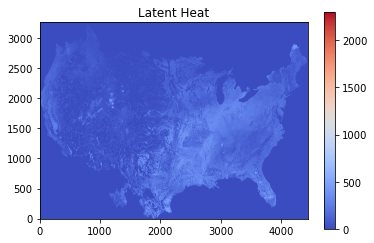

In [14]:
print(np.shape(overland_flow))
print(np.shape(pressure_arrays))

plt.imshow(overland_flow[20,:,:], cmap="Blues", origin='lower', vmin = 0, vmax = 500)
#plt.colorbar()
plt.title('Overland Flow')
plt.show()
plt.imshow(wtd[10,:,:], cmap="Blues_r", origin='lower')
#plt.colorbar()
plt.title('WTD')
plt.show()

#print out all CLM variables avilable
print(data.clm_output_variables)
# set timestep to visualize
data.time = 20
# filter out inactive cells
LH_plot = np.where(data.clm_output(field='eflx_lh_tot') > -99, data.clm_output(field='eflx_lh_tot'), 0.)
im = plt.imshow(LH_plot, cmap="coolwarm", origin='lower')
#plt.show(im)
plt.title('Latent Heat')
plt.colorbar(im)

#### Plotting components of water balance

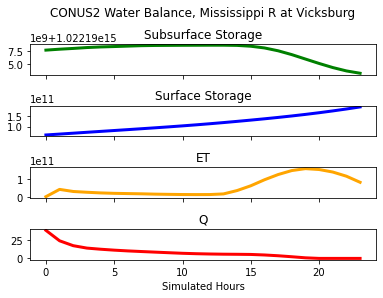

In [15]:
#plotting components of water balance
fig, axs = plt.subplots(4, sharex=True)
fig.suptitle('CONUS2 Water Balance, Mississippi R at Vicksburg')
axs[0].plot(subsurface_storage[0:24], linewidth=3, color = "green")
axs[0].set_title("Subsurface Storage")
axs[1].plot(surface_storage[0:24], linewidth=3, color = "blue")
axs[1].set_title("Surface Storage")
axs[2].plot(et[0:24], linewidth=3, color = "orange")
axs[2].set_title("ET")
axs[3].plot(overland_flow[0:24,2770, 847], linewidth=3, color = "red")
axs[3].set_title("Q")
plt.xlabel('Simulated Hours')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.85, 
                    wspace=0.7, 
                    hspace=1.0)
axs[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

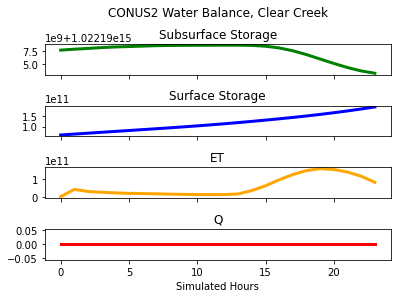

In [16]:
#plotting components of water balance
fig, axs = plt.subplots(4, sharex=True)
fig.suptitle('CONUS2 Water Balance, Clear Creek')
axs[0].plot(subsurface_storage[0:24], linewidth=3, color = "green")
axs[0].set_title("Subsurface Storage")
axs[1].plot(surface_storage[0:24], linewidth=3, color = "blue")
axs[1].set_title("Surface Storage")
axs[2].plot(et[0:24], linewidth=3, color = "orange")
axs[2].set_title("ET")
axs[3].plot(overland_flow[0:24,1528,1679], linewidth=3, color = "red")
axs[3].set_title("Q")
plt.xlabel('Simulated Hours')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.85, 
                    wspace=0.7, 
                    hspace=1.0)
axs[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

#### Save txt files of storage, et, overland flow

In [27]:
# save out 1D outputs to text files
np.savetxt(f'{run_dir}/water_balance/subsurface_storage_{run_name}.txt', subsurface_storage[0:25], delimiter=",")
np.savetxt(f'{run_dir}/water_balance/surface_storage_{run_name}.txt', surface_storage[0:25], delimiter=",")
np.savetxt(f'{run_dir}/water_balance/et_{run_name}.txt', et[0:25], delimiter=",")

In [28]:
# save all 24 timesteps of overland flow to text files
# use zfill to fill 6 digits with leading zeros
for i in range(len(overland_flow[0:25])):
    np.savetxt(f'{run_dir}/water_balance/overland_flow_{str(i).zfill(6)}_{run_name}.txt', overland_flow[i,:,:], delimiter=",") 

### Water Balance Calculations

#### 2. Normalize water balance quantities by active CONUS2 area using PFTools ET
Note 7/21 - This I'm not sure is correct. Current logic is that the PFTools outputs ET in a volume, so probably mm^3/s. Multiply this by 3600 s/h to get mm^3/h. Then divide by CONUS2 area, which is converted from km^2 to mm^2 (then you basically have mm^3/s * 1/mm^2). However, if you wanted to really make the units make sense, you would actually divide by 1e12 for km2 to mm2 (not 1e6, which is km to mm).

In [20]:
et_array = np.loadtxt(f'{run_dir}/water_balance/et_r1_test.txt') #[mm^3/s]
et_array = et_array/1000*3600#[mm^3/s] -> [mm^3/h]
et_array

array([0.00000000e+00, 1.45590268e+11, 1.03807135e+11, 8.83074660e+10,
       7.53059085e+10, 6.68574187e+10, 6.19123438e+10, 5.73467584e+10,
       5.07269047e+10, 4.65779810e+10, 4.31291909e+10, 4.19702438e+10,
       4.27339755e+10, 5.52261413e+10, 1.22860197e+11, 2.18033580e+11,
       3.37812885e+11, 4.42141287e+11, 5.21757992e+11, 5.60343205e+11,
       5.42708130e+11, 4.92315594e+11, 4.08911932e+11, 2.87378788e+11,
       1.68285691e+11])

In [21]:
cumET = np.cumsum(et_array) # [mm^3/d]
conus_area = 7852823*1e6#km^2 to mm^2 ??? do you also multiply by number of layers because calculate_evapotranspiration() does nx*ny*nz, so *10 ??? 
normET = cumET[-1]/conus_area
print(f'ET over CONUS2 for 24 hour period: {round(normET, 5)} mm/d')

ET over CONUS2 for 24 hour period: 0.63443 mm/d


In [22]:
cumET

array([0.00000000e+00, 1.45590268e+11, 2.49397403e+11, 3.37704869e+11,
       4.13010777e+11, 4.79868196e+11, 5.41780540e+11, 5.99127298e+11,
       6.49854203e+11, 6.96432184e+11, 7.39561375e+11, 7.81531619e+11,
       8.24265594e+11, 8.79491735e+11, 1.00235193e+12, 1.22038551e+12,
       1.55819840e+12, 2.00033969e+12, 2.52209768e+12, 3.08244088e+12,
       3.62514901e+12, 4.11746461e+12, 4.52637654e+12, 4.81375533e+12,
       4.98204102e+12])

#### A. Check ET with clm_output 'qflx_evap_tot'

In [23]:
# 4: qflx_evap_tot for total evaporation [mm/s]
qflx_evap_CLM = np.zeros((24, ny, nx))
for i in range(24):    
    CLM_file = pf.read_pfb(f'{run_dir}/{run_name}.out.clm_output.{str(i+1).zfill(5)}.C.pfb')
    CLM_file[CLM_file<-9000] = 0 # set values outside of the domain to zero
    qflx_evap_CLM[i, ...] = CLM_file[4,...] # fill qflx_evap_CLM array by flagging the 4 position in the CLM file

(24, 3256, 4442)


Text(0.5, 1.0, 'net veg. evaporation and transpiration and soil evaporation (mms-1) for hour 1')

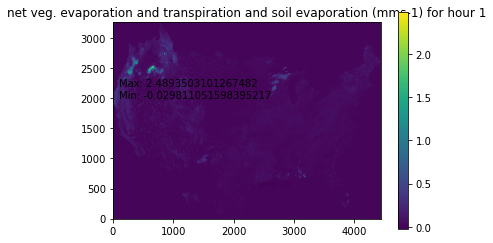

In [24]:
# convert ET from mm/s to mm/h
qflx_evap_CLM = qflx_evap_CLM*3600

# checking evap flux values and make sure that loop worked
print(qflx_evap_CLM.shape)
t = 0 #select timestep (hour) to plot
plt.imshow(qflx_evap_CLM[t,...], origin="lower")
plt.colorbar()
plt.annotate(f'Max: {qflx_evap_CLM[t].max()}', xy = (100,2200))
plt.annotate(f'Min: {qflx_evap_CLM[t].min()}', xy = (100,2000))
plt.title(f'net veg. evaporation and transpiration and soil evaporation (mms-1) for hour {t+1}')

array([ 371403.74373014,  264814.12022719,  225274.148031  ,
        192106.90949727,  170554.63966719,  157939.65254827,
        146292.75113762,  129405.36915022,  118821.38021457,
        110023.44607859,  107066.94835951,  109015.24362987,
        140883.01362261,  313418.87053011,  556208.11150409,
        861767.56481352, 1127911.44704588, 1331015.28594622,
       1429446.95103016, 1384459.51646164, 1255907.12861043,
       1043142.68311337,  733109.15186155,  429300.23156751])

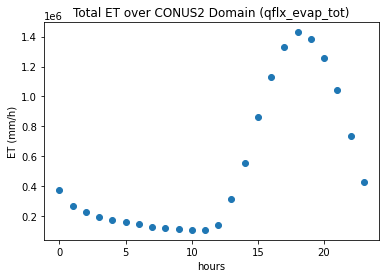

In [26]:
# sum all cells for every hour to get total hourly ET for entire CONUS2 domain
total_qflx_evap = np.zeros(24)

for i in range(24):
    total_qflx_evap[i] = np.sum(qflx_evap_CLM[i, ...])
plt.scatter(range(24),total_qflx_evap)
plt.xlabel("hours")
plt.ylabel("ET (mm/h)")
plt.title("Total ET over CONUS2 Domain (qflx_evap_tot)")
total_qflx_evap